
#Skin Cancer Segmentation using DeepLab

I've written the model architecture from scratch in PyTorch. To hasten the training, weights from the first few layers of ResNet-18 are transfered to this ResNet module.



In [0]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
data_path='/content/drive/My Drive/DATA/DATA/'

## Load Pickled Data
We've rescaled the image data to the range [0.0, 1.0] and stored as a pickle for fast loading

In [0]:
train_img_x,train_img_y,val_img_x,val_img_y=pickle.load(open('/content/drive/My Drive/DATA/cancer_rescaled.pkl',mode='rb'))
test_img_x, test_img_y = pickle.load(open('/content/drive/My Drive/DATA/test.pkl', mode='rb'))

print(train_img_x.max(), val_img_x.max(), test_img_x.max())
print(train_img_x.min(), val_img_x.min(), test_img_x.min())

tensor(1.) tensor(1.) tensor(1.)
tensor(0.) tensor(0.) tensor(0.)


## Model Construction

In [0]:
class Resnet(nn.Module):
    def __init__(self):
        super().__init__()

        resnet18 = torchvision.models.resnet18(pretrained=True)
        
        self.initial_layer = nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            nn.ReLU()
        )
        
        #not using maxpool
        # self.maxpool1 = resnet18.maxpool

        self.layer1 = resnet18.layer1
        self.layer2 = resnet18.layer2
        self.layer3 = resnet18.layer3

    def forward(self, xb):
        x = self.initial_layer(xb)

        x = self.layer1(x)
        x1 = self.layer2(x)
        x1 = self.layer3(x1)

        return x1, x

In [0]:
class aspp(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.inplane = 256
    self.aspp_outchannels = 128
    self.overall_outchannels = 256
    #dilations of [1, 6, 12, 12, 18] is too big for our resnet features which are around 22×32
    self.dilation=[1, 3, 5, 7, 9]
    self.aspp1=self.aspp_layer(self.inplane, self.aspp_outchannels,(1,1),self.dilation[0],pad=0)
    self.aspp2=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[1],pad=self.dilation[1])
    self.aspp3=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[2],pad=self.dilation[2])
    self.aspp4=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[3],pad=self.dilation[3])
    self.aspp5=self.aspp_layer(self.inplane, self.aspp_outchannels,(3,3),self.dilation[4],pad=self.dilation[4])
    
    self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(self.inplane, self.aspp_outchannels, (1,1), stride=1, bias=False),
    #TODO: HOW TO MAKE THIS WORK?
                                            #  nn.BatchNorm2d(self.aspp_outchannels),
                                             nn.ReLU())
    
    self.conv1 = nn.Conv2d(6 * self.aspp_outchannels, self.overall_outchannels, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(self.overall_outchannels)
    self.relu = nn.ReLU()
    
  def aspp_layer(self,in_chan,out_chan,ksize,dilation,pad):
    return nn.Sequential(nn.Conv2d(in_chan,out_chan,kernel_size=ksize,padding=pad,dilation=dilation),
                         nn.BatchNorm2d(out_chan),
                         nn.ReLU())
  
  def forward(self,x):
    x1=self.aspp1(x)
    x2=self.aspp2(x)
    x3=self.aspp3(x)
    x4=self.aspp4(x)
    x5=self.aspp5(x)
    xa=self.global_avg_pool(x)
    xa = F.interpolate(xa, size=x5.size()[2:], mode='bilinear', align_corners=True)
    x = torch.cat((x1, x2, x3, x4, x5, xa), dim=1)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    
    return x
    
  

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.early_features_inchannels = 64

        self.early_features_conv = nn.Sequential(
            nn.Conv2d(self.early_features_inchannels, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

        #Should we add SKIP CONNECTIONS in this conv block as well?

        ####
        # self.short_conv = nn.Sequential(
        #     nn.Conv2d(256 + 48, num_classes)
        # )
        ####
        
        self.last_conv = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1, stride=1, padding=0, bias=False)
        )

    def forward(self, xb, early_features):
        features = self.early_features_conv(early_features)

        xb = F.interpolate(xb, features.shape[2:], mode='bilinear', align_corners=True)
        xb = torch.cat((xb, features), dim=1)

        return self.last_conv(xb)

In [0]:
class DeepLab(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.num_classes = num_classes

        self.resnet = Resnet().to(device)
        self.aspp = aspp().to(device)
        self.decoder = Decoder(num_classes=num_classes).to(device)

    def forward(self, xb):
        x, early_features = self.resnet(xb)
        x = self.aspp(x)
        x = self.decoder(x, early_features)

        return F.interpolate(x, xb.shape[2:], mode='bilinear', align_corners=True)

In [0]:
x = torch.randn(10,3,192,256).to(device)

In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

def get_deeplab(num_classes):
    model = DeepLab(num_classes=num_classes).to(device)

    for p in model.resnet.parameters():
        p.requires_grad = False
    
    # model.apply(weights_init)

    return model

### This Deeplab Model has ~5.5 Million Parameters
We're training only about 2.7 Million

In [0]:
def count_params_all(model):
    return sum(p.numel() for p in model.parameters())

def count_params_trainable(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
deeplab = get_deeplab(1)

In [0]:
count_params_all(deeplab), count_params_trainable(deeplab)

(5521696, 2738912)

In [0]:
bce_loss = torch.nn.BCEWithLogitsLoss()

In [0]:
import random

def get_batches(bs):
    idxs = np.random.permutation(len(train_img_x))

    for i in tqdm(range(0, len(idxs) - bs + 1, bs)):
        res_x, res_y = train_img_x[ idxs[i:i+bs] ].clone(), train_img_y[ idxs[i:i+bs] ].clone()

        #randomly choose between 4 options:
        c = random.randint(0, 3)

        if c == 0:
            #leave image as is
            yield res_x, res_y
        elif c == 1:
            #flip sideways
            yield res_x.flip(2), res_y.flip(1)
        elif c == 2:
            #flip upwards
            yield res_x.flip(3), res_y.flip(2)
        elif c == 3:
            #flip both sideways and upwards. In effect, do a 180° turn
            yield res_x.flip(3).flip(2), res_y.flip(2).flip(1)

def get_batches_small(bs):
    #for quick LR-Find
    idxs = np.random.permutation(300)

    for i in tqdm(range(0, len(idxs) - bs + 1, bs)):
        yield train_img_x[ idxs[i:i+bs] ], train_img_y[ idxs[i:i+bs] ]

In [0]:
def get_val_loss_accuracy(model, device='cuda'):
    model.eval()
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(zip(val_img_x, val_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = IoU_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

def IoU_accuracy(y_preds, y_real, t=0.5, plot=False):
    '''Intersection over Union metric'''
    # print(y_preds.dtype, y_preds.shape)
    # print(tmp.dtype)
    thres = (y_preds > t).type(torch.ByteTensor)
    realz = y_real.type(torch.ByteTensor)

    intersect = (thres & realz).sum().float() 
    union = (thres | realz).sum().float()
    result = intersect / union
    # print(intersect, union, res)

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(thres)
        plt.subplot(3, 2, 2)
        plt.imshow(realz)

        plt.subplot(3, 2, 3)
        plt.imshow(thres & realz)
        plt.subplot(3, 2, 4)
        plt.imshow(thres | realz)

        plt.subplot(3, 2, 5)
        plt.imshow(y_preds)
        plt.subplot(3, 2, 6)
        plt.imshow(y_real)

    return result.item()

def Dice_accuracy(y_preds, y_real, t=0.5, plot=False):
    '''2 * Intersection / (real.sum() + prediction.sum())'''
    # print(y_preds.dtype, y_preds.shape)
    # print(tmp.dtype)
    thres = (y_preds > t).type(torch.ByteTensor)
    realz = y_real.type(torch.ByteTensor)

    intersect = (thres & realz).sum().float() 
    union = (thres | realz).sum().float() 
    result = (intersect + intersect) / (union + intersect)
    # print(intersect, union, res)

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(thres)
        plt.subplot(3, 2, 2)
        plt.imshow(realz)

        plt.subplot(3, 2, 3)
        plt.imshow(thres & realz)
        plt.subplot(3, 2, 4)
        plt.imshow(thres | realz)

        plt.subplot(3, 2, 5)
        plt.imshow(y_preds)
        plt.subplot(3, 2, 6)
        plt.imshow(y_real)

    return result.item()

In [0]:
def get_val_loss_accuracy_DICE(model, device='cuda'):
    model.eval()
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        for x, y in tqdm(zip(val_img_x, val_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = Dice_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

In [0]:
def train_loop(model, epochs=1, lr=0.1, bs=25, weight_decay=0.00001, device='cuda'):
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  for epoch in range(epochs):
    loss_t=0
    
    model.train()

    for xb, yb in get_batches(bs=bs):      
      preds = model(xb.to(device))
      preds=preds.squeeze(1)

      loss = bce_loss(preds,yb.to(device))
      
      loss.backward()

      nn.utils.clip_grad_norm_(model.parameters(), 10.0)

      optimizer.step()
      optimizer.zero_grad()
      
      loss_t += loss.detach()
      
    model.eval()

    val_loss, Dice_acc = get_val_loss_accuracy(model, device)
    val_losses.append(val_loss)
    accuracies.append(Dice_acc)

    train_losses.append(loss_t / (len(train_img_x) / bs))

    print("val_loss: {} | accuracy: {} | train_loss: {}".format(val_losses[-1], accuracies[-1], train_losses[-1]))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(val_losses, label='validation loss')
  plt.plot(train_losses, label='training loss')
  plt.legend(loc='upper right') 
  plt.subplot(1, 2, 2) 
  plt.plot(accuracies, label="accuracy")
  plt.legend(loc='upper right')
  plt.show()

In [0]:
find_losses = []

def train_loop_find(model, epochs=1, lr=0.006, bs=25, device='cuda'):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    loss_t=0
    for xb, yb in get_batches_small(bs=bs):

      model.train()
      
      preds = model(xb.to(device))
      preds=preds.squeeze(1)
    #   print(preds.shape, yb.shape)
      loss = bce_loss(preds,yb.to(device))
      
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      loss_t += loss.detach()
      
    model.eval()
    print("lr : {} | train_loss: {}"
            .format(lr, loss_t / (len(train_img_x) / bs))
    )

    find_losses.append(loss_t / (len(train_img_x) / bs))


### check untrained accuracy

In [0]:
get_val_loss_accuracy(deeplab)

150it [00:05, 25.23it/s]


(0.6910283386707305, 0.011070042069186457)

### Store params every few epochs so we can visualize changes in conv filters later

In [0]:
params_list = []

In [0]:
def show_convs_firstlayer(model, params_idx, num=5):
    plt.figure(figsize=(3, num*3))
    for i, weights in enumerate(params_list[params_idx][1][0][:num]):
        plt.subplot(num, 1, i+1)
        plt.imshow((weights.detach().cpu().permute(1, 2, 0) + 1.0) / 2.0)
        print("filter #{}: max: {} min: {}".format(i, weights.max().item(), weights.min().item()))

In [0]:
params_list.append(
    ('untrained', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

In [0]:
params_list[0][1][0].shape

torch.Size([64, 3, 7, 7])

In [0]:
show_convs_firstlayer(deeplab, 0, 10)

## Find an optimal LR range
The idea is to train single epochs on a small subset of data, and see which range for LR give the maximum slope.

  0%|          | 0/12 [00:00<?, ?it/s]

lr : 1e-06 | train_loss: 0.10137183964252472


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 2.0691380811147897e-06 | train_loss: 0.09858791530132294


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 4.281332398719394e-06 | train_loss: 0.09298109263181686


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 8.858667904100827e-06 | train_loss: 0.08314988017082214


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 1.8329807108324358e-05 | train_loss: 0.06793280690908432


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 3.79269019073225e-05 | train_loss: 0.05094929412007332


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 7.847599703514613e-05 | train_loss: 0.03762112557888031


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.00016237767391887218 | train_loss: 0.032227348536252975


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0003359818286283782 | train_loss: 0.02792808972299099


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0006951927961775607 | train_loss: 0.028450030833482742


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0014384498882876629 | train_loss: 0.029453475028276443


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0029763514416313187 | train_loss: 0.03511744365096092


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.006158482110660265 | train_loss: 0.03052462637424469


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.01274274985703134 | train_loss: 0.02798020839691162


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.026366508987303586 | train_loss: 0.03317444026470184


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.0545559478116852 | train_loss: 0.036269426345825195


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.11288378916846892 | train_loss: 0.03872504457831383


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.23357214690901226 | train_loss: 0.07514939457178116


  0%|          | 0/12 [00:00<?, ?it/s]

lr : 0.48329302385717543 | train_loss: 0.10668816417455673


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


lr : 1.0000000000000002 | train_loss: 0.08714766800403595


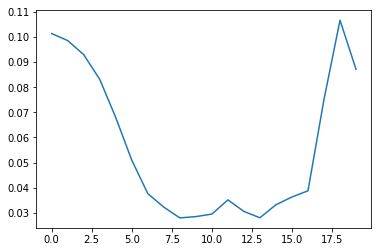

In [0]:
find_losses = []

low = 0.000001
high = 1.0
steps = 20
alpha = (high / low) ** (1 / (steps - 1))

m = get_deeplab(1)
# lrs = []

for step in range(steps):
    eta = low * (alpha ** step)
    train_loop_find(m, 1, lr=eta)
    # lrs.append(eta)

# plt.plot(lrs)

plt.plot(find_losses)

## LR range : [1e-5 , 3e-3]

In [0]:
deeplab = get_deeplab(1)

val_losses = []
train_losses = []
accuracies = []

# Train

### Warmup first

100%|██████████| 50/50 [01:12<00:00,  1.47s/it]
150it [00:06, 23.16it/s]


val_loss: 0.4334938188393911 | accuracy: 0.44599660667280355 | train_loss: 0.550700843334198


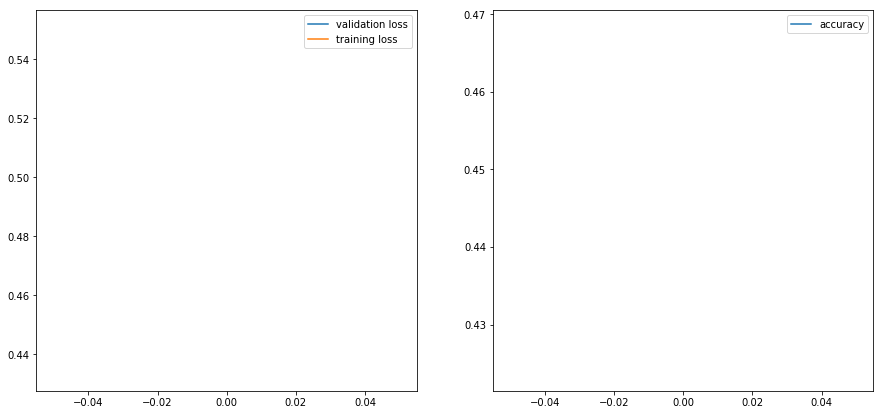

100%|██████████| 50/50 [01:12<00:00,  1.50s/it]
150it [00:06, 23.28it/s]


val_loss: 0.20049308960636456 | accuracy: 0.6607595703572345 | train_loss: 0.2272832691669464


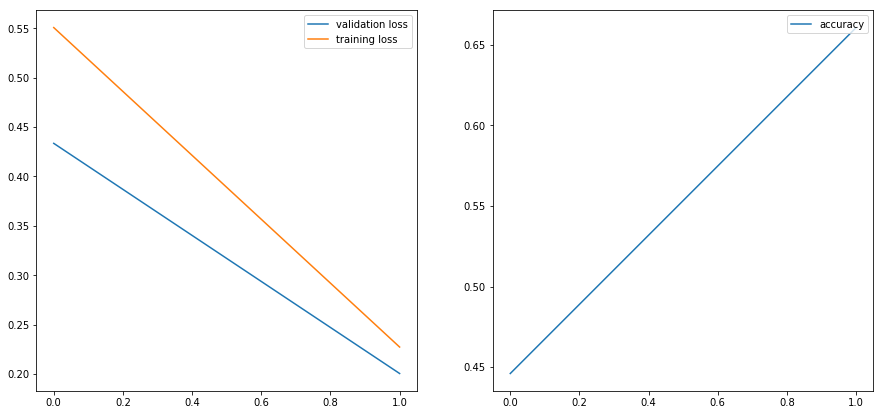

100%|██████████| 50/50 [01:12<00:00,  1.43s/it]
150it [00:06, 23.32it/s]


val_loss: 0.17837933639064432 | accuracy: 0.6890032779425382 | train_loss: 0.16321907937526703


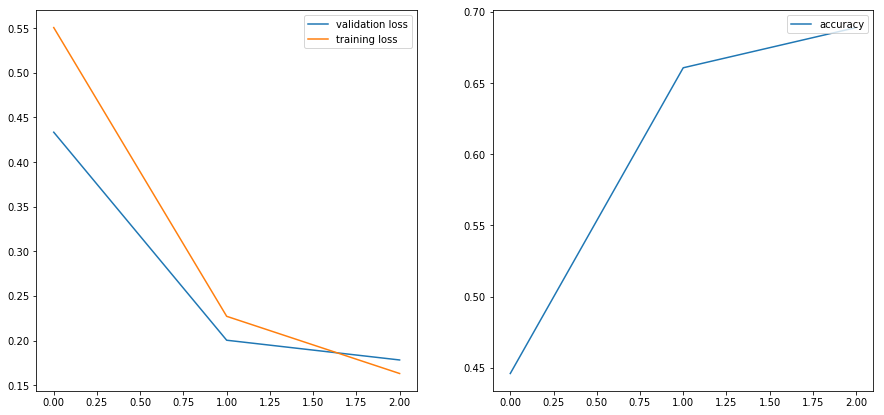

In [0]:
train_loop(deeplab, lr=0.00001, epochs=1)
train_loop(deeplab, lr=0.0001, epochs=1)
train_loop(deeplab, lr=0.001, epochs=1)

params_list.append(
    ('post warmup', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

100%|██████████| 50/50 [01:12<00:00,  1.49s/it]
150it [00:06, 23.27it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.2076041230124732 | accuracy: 0.5927700548929473 | train_loss: 0.14294515550136566


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.36it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.18934085768957934 | accuracy: 0.6546963687054813 | train_loss: 0.1242123544216156


100%|██████████| 50/50 [01:11<00:00,  1.44s/it]
150it [00:06, 23.36it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16235107697546483 | accuracy: 0.6615359180017064 | train_loss: 0.11690124869346619


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.12it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16629805184279878 | accuracy: 0.7039704288542271 | train_loss: 0.1070656105875969


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]
150it [00:06, 23.30it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1618334913936754 | accuracy: 0.6648486835012833 | train_loss: 0.11161310225725174


100%|██████████| 50/50 [01:11<00:00,  1.47s/it]
150it [00:06, 23.26it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16753884601717195 | accuracy: 0.6970538451770941 | train_loss: 0.10070449858903885


100%|██████████| 50/50 [01:11<00:00,  1.44s/it]
150it [00:06, 23.46it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.20185695730149747 | accuracy: 0.6474853552288066 | train_loss: 0.09874780476093292


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]
150it [00:06, 23.27it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1725315057237943 | accuracy: 0.6835796238978704 | train_loss: 0.10419531911611557


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.26it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16402989195038875 | accuracy: 0.67427376147282 | train_loss: 0.09891970455646515


100%|██████████| 50/50 [01:12<00:00,  1.49s/it]
150it [00:06, 23.34it/s]


val_loss: 0.15951699853874743 | accuracy: 0.6685278914123773 | train_loss: 0.09774672240018845


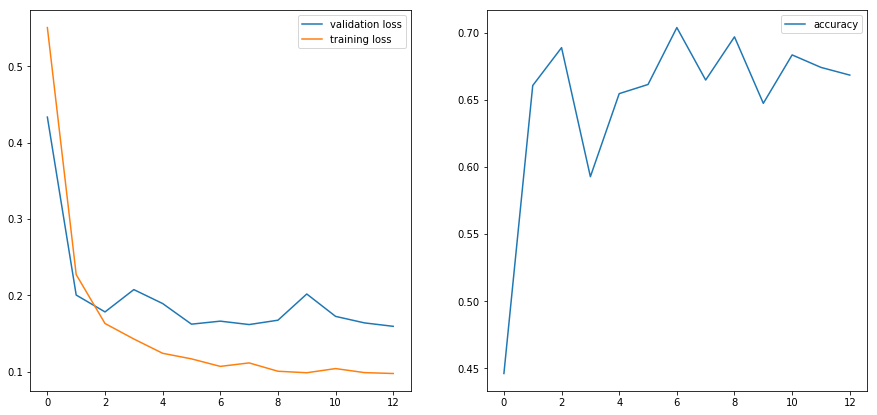

filter #0: max: 0.7703464031219482 min: -0.5926986336708069
filter #1: max: 0.2860589623451233 min: -0.3222135901451111
filter #2: max: 2.1503893776753102e-07 min: -1.3309079349710373e-07
filter #3: max: 0.0734558254480362 min: -0.16960349678993225
filter #4: max: 1.0887553081317947e-08 min: -1.2552678008148632e-08


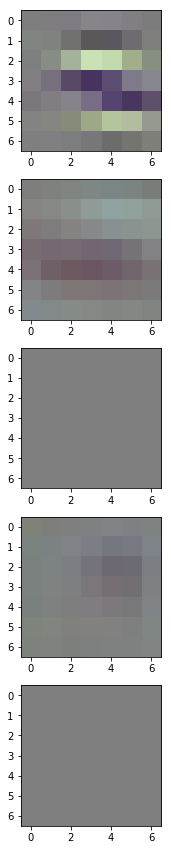

In [0]:
train_loop(deeplab, lr=0.002, epochs=10, weight_decay=0.0001)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint41")

params_list.append(
    ('first cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 2, 5)

100%|██████████| 50/50 [01:12<00:00,  1.48s/it]
150it [00:06, 23.34it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14671409126060705 | accuracy: 0.7332237606247266 | train_loss: 0.08597426116466522


100%|██████████| 50/50 [01:12<00:00,  1.43s/it]
150it [00:06, 23.33it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1474360017493988 | accuracy: 0.7350164646406968 | train_loss: 0.08261573314666748


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.32it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14476317076943815 | accuracy: 0.73937722971042 | train_loss: 0.07984980195760727


100%|██████████| 50/50 [01:12<00:00,  1.43s/it]
150it [00:06, 23.31it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.15559161953938505 | accuracy: 0.7340070586899916 | train_loss: 0.07923053950071335


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.37it/s]


val_loss: 0.14339909095627565 | accuracy: 0.7394235019385814 | train_loss: 0.07756006717681885


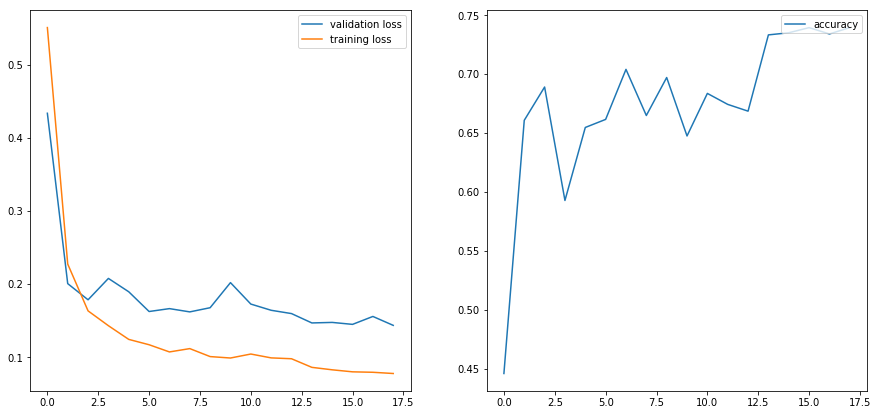

In [0]:
train_loop(deeplab, lr=0.0002, epochs=5, weight_decay=0.00001)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint42")

params_list.append(
    ('second cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

# show_convs_firstlayer(deeplab, 2, 5)

In [0]:
# deeplab = get_deeplab(1)
# deeplab.load_state_dict(torch.load("/content/drive/My Drive/DATA/deeplab_takethree_checkpoint11"))
# deeplab.eval()

## Unfreeze now or later?
### Let's try both

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]
150it [00:06, 23.26it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14051205301346878 | accuracy: 0.7439039878050486 | train_loss: 0.07670335471630096


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.28it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14795523898055157 | accuracy: 0.7436259948710601 | train_loss: 0.07295272499322891


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.36it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.15169862462052455 | accuracy: 0.7419750369091829 | train_loss: 0.07405786216259003


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.33it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.15069903028818468 | accuracy: 0.742460160702467 | train_loss: 0.07318900525569916


100%|██████████| 50/50 [01:12<00:00,  1.43s/it]
150it [00:06, 23.32it/s]


val_loss: 0.14511110209859907 | accuracy: 0.7436726528406143 | train_loss: 0.07422763854265213


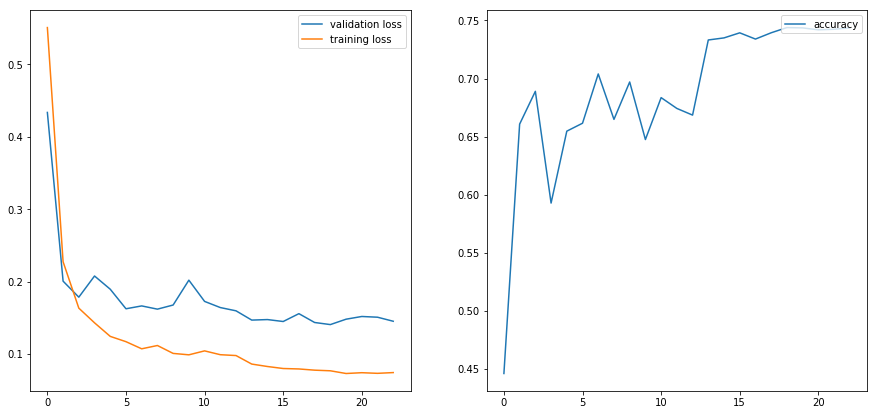

filter #0: max: 0.7703464031219482 min: -0.5926986336708069
filter #1: max: 0.2860589623451233 min: -0.3222135901451111
filter #2: max: 2.1503893776753102e-07 min: -1.3309079349710373e-07
filter #3: max: 0.0734558254480362 min: -0.16960349678993225
filter #4: max: 1.0887553081317947e-08 min: -1.2552678008148632e-08


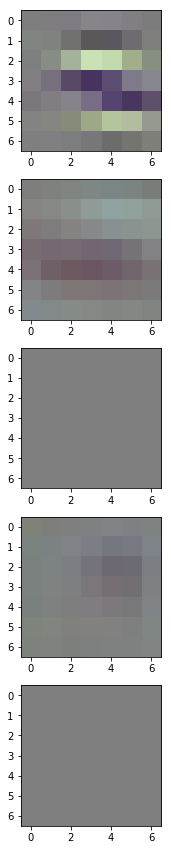

In [0]:
train_loop(deeplab, lr=0.00005, epochs=5, weight_decay=0.000005)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint43")

params_list.append(
    ('third cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

show_convs_firstlayer(deeplab, 4, 5)

Weights are quite small for the Conv2d layers. Let's train at a higher LR for some time

100%|██████████| 50/50 [01:12<00:00,  1.44s/it]
150it [00:06, 23.30it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16031061517074705 | accuracy: 0.7174150734891495 | train_loss: 0.08453932404518127


100%|██████████| 50/50 [01:12<00:00,  1.50s/it]
150it [00:06, 23.45it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14309048651717604 | accuracy: 0.7395563021798929 | train_loss: 0.08071473985910416


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]
150it [00:06, 23.20it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14998201195616276 | accuracy: 0.7350115563472112 | train_loss: 0.07924611121416092


100%|██████████| 50/50 [01:12<00:00,  1.45s/it]
150it [00:06, 23.20it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16280562835124632 | accuracy: 0.7249739326257258 | train_loss: 0.07821321487426758


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]
150it [00:06, 23.22it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.16058189956471325 | accuracy: 0.7346522408723831 | train_loss: 0.08337242901325226


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.38it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1542333722083519 | accuracy: 0.7299034352103869 | train_loss: 0.07780198752880096


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]
150it [00:06, 23.34it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.15426440127504368 | accuracy: 0.7308154229819774 | train_loss: 0.0787767767906189


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
150it [00:06, 23.30it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1497255728766322 | accuracy: 0.7438662089407444 | train_loss: 0.07449416071176529


100%|██████████| 50/50 [01:13<00:00,  1.44s/it]
150it [00:06, 23.41it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.13204331550126275 | accuracy: 0.7488403528928756 | train_loss: 0.07617426663637161


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]
150it [00:06, 23.35it/s]


val_loss: 0.16440376240294427 | accuracy: 0.7101221077640851 | train_loss: 0.0741601213812828


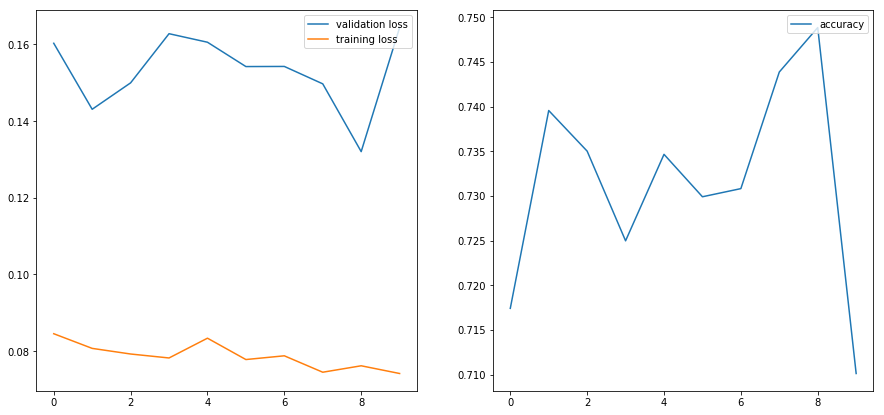

IndexError: ignored

<Figure size 216x1080 with 0 Axes>

In [0]:
# for p in deeplab.parameters():
#     p.requires_grad = True

deeplab.load_state_dict(torch.load("/content/drive/My Drive/DATA/deeplab_takethree_checkpoint43"))

train_loop(deeplab, lr=0.001, epochs=10, weight_decay=0.00005)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint44")

params_list.append(
    ('fifth cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

# show_convs_firstlayer(deeplab, 0, 5)

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]
150it [00:06, 23.30it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14333363217456888 | accuracy: 0.7520454519242048 | train_loss: 0.06579206138849258


100%|██████████| 50/50 [01:11<00:00,  1.45s/it]
150it [00:06, 23.31it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.14556467089181144 | accuracy: 0.7537574404974778 | train_loss: 0.0659736692905426


100%|██████████| 50/50 [01:12<00:00,  1.47s/it]
150it [00:06, 23.36it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.15113144649658353 | accuracy: 0.7554634325702985 | train_loss: 0.061840031296014786


100%|██████████| 50/50 [01:11<00:00,  1.47s/it]
150it [00:06, 23.35it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

val_loss: 0.1647483554777379 | accuracy: 0.7524806565543016 | train_loss: 0.06223350390791893


100%|██████████| 50/50 [01:12<00:00,  1.49s/it]
150it [00:06, 23.31it/s]


val_loss: 0.14792890167950343 | accuracy: 0.7552942431469758 | train_loss: 0.060515597462654114


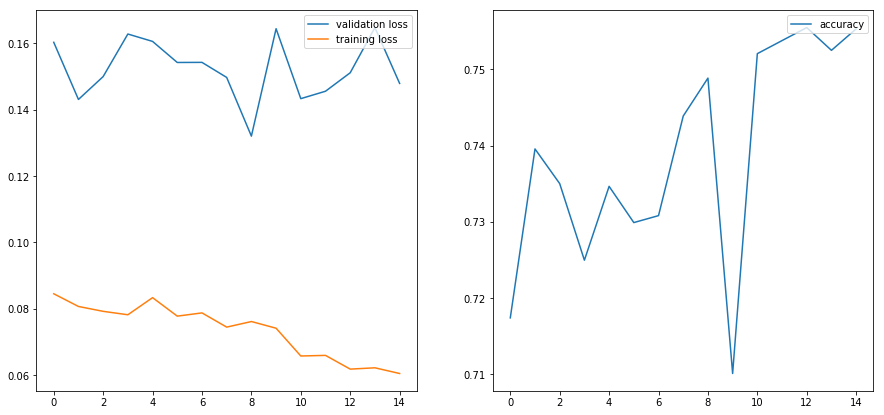

In [0]:
train_loop(deeplab, lr=0.0002, epochs=5, weight_decay=0.00005)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint45")

params_list.append(
    ('some cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

## Training ASPP Layers Only
Looks like those layers have extremely small weights

In [0]:
deeplab.load_state_dict(torch.load("/content/drive/My Drive/DATA/deeplab_takethree_checkpoint45"))

for p in deeplab.parameters():
    print(p.requires_grad)

print("\n\n\n")

for p in deeplab.aspp.parameters():
    print(p.requires_grad)

In [0]:
# for p in deeplab.parameters():
#     p.requires_grad = False

# for p in deeplab.aspp.parameters():
#     p.requires_grad = True

for p in deeplab.parameters():
    print(p.requires_grad)

print("\n\n\n")

for p in deeplab.aspp.parameters():
    print(p.requires_grad)

In [0]:
get_val_loss_accuracy(deeplab)

150it [00:05, 26.19it/s]


(0.14792890167950343, 0.7552942431469758)

100%|██████████| 80/80 [01:21<00:00,  1.03s/it]
150it [00:05, 26.52it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.14673894364386797 | accuracy: 0.739851045012474 | train_loss: 0.08669308573007584


100%|██████████| 80/80 [01:23<00:00,  1.07s/it]
150it [00:05, 26.85it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.14324383453465997 | accuracy: 0.7450932896633943 | train_loss: 0.0824480950832367


100%|██████████| 80/80 [01:19<00:00,  1.11it/s]
150it [00:05, 26.80it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.1484553301598256 | accuracy: 0.7424997393786907 | train_loss: 0.0825490802526474


100%|██████████| 80/80 [01:21<00:00,  1.01it/s]
150it [00:05, 26.84it/s]
  0%|          | 0/80 [00:00<?, ?it/s]

val_loss: 0.13950377922349919 | accuracy: 0.7426328740393122 | train_loss: 0.08139782398939133


100%|██████████| 80/80 [01:26<00:00,  1.02s/it]
150it [00:05, 26.83it/s]


val_loss: 0.16046702462869386 | accuracy: 0.7388662671049436 | train_loss: 0.08131726831197739


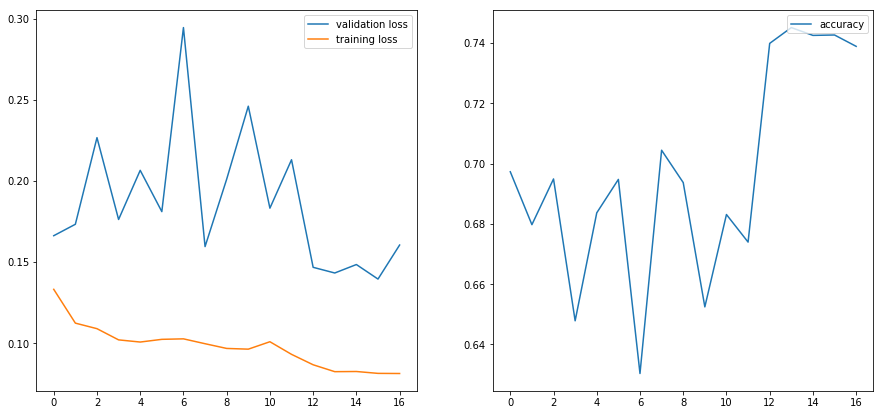

In [0]:
train_loop(deeplab, lr=0.001, epochs=5, weight_decay=0.00005)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint_TrainingASPPOnly_1")

params_list.append(
    ('some cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

In [0]:
for p in deeplab.parameters():
    p.requires_grad = True

train_loop(deeplab, lr=0.0001, epochs=3, weight_decay=0.00001)

torch.save(deeplab.state_dict(), "/content/drive/My Drive/DATA/deeplab_takethree_checkpoint_Training_final")

params_list.append(
    ('some cycle', [p.clone().detach().cpu() for p in deeplab.parameters()])
)

In [0]:
deeplab.load_state_dict(torch.load("/content/drive/My Drive/DATA/deeplab_takethree_checkpoint35"))

<All keys matched successfully>

In [0]:
get_val_loss_accuracy(deeplab)

150it [00:05, 26.51it/s]


(0.1393340126207719, 0.7497711530327797)

In [0]:
def compare_convs_first_layer(num=7):
    plt.figure(figsize=(len(params_list)*1.5, num * 1.5))
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    for i in range(num):
        for j in range(len(params_list)):
            plt.subplot(num, len(params_list), i * len(params_list) + j + 1)
            plt.imshow((params_list[j][1][0][i].permute(1, 2, 0).detach().cpu() + 1) / 2.0)

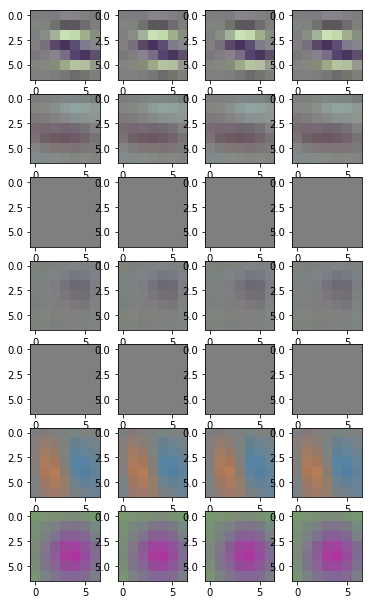

In [0]:
compare_convs_first_layer()

In [0]:
deeplab.load_state_dict(torch.load("/content/drive/My Drive/DATA/deeplab_taketwo_checkpoint16"))

<All keys matched successfully>

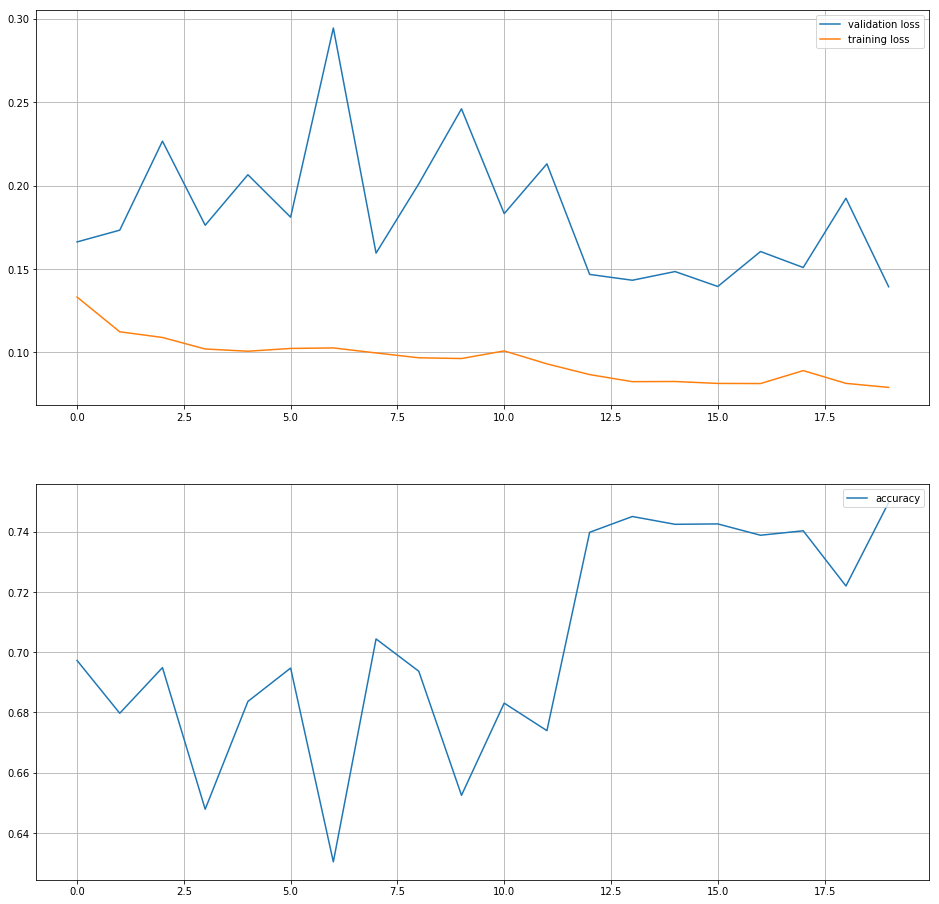

In [0]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(val_losses, label='validation loss')
plt.plot(train_losses, label='training loss')
plt.grid(b=True, which='both')
plt.legend(loc='upper right') 
plt.subplot(2, 1, 2) 
plt.plot(accuracies, label="accuracy")
plt.grid(b=True, which='both')
plt.legend(loc='upper right')
plt.show()

## Some segmentation examples

In [0]:
def show_random_pairs(model, num_examples=3):
    plt.figure(figsize=(20, 5*num_examples))
    for i, idx in enumerate(np.random.permutation(len(val_img_x))[:num_examples]):
        print("val img x  min:{} max:{} mean:{}".format(val_img_x[idx].min(), val_img_x[idx].max(), val_img_x[idx].mean()))
        plt.subplot(num_examples, 3, 3*i + 1)
        plt.imshow(val_img_y[idx])
        plt.subplot(num_examples, 3, 3*i + 2)
        plt.imshow(val_img_x[idx].permute(1, 2, 0))
        plt.subplot(num_examples, 3, 3*i + 3)
        with torch.no_grad():
            preds = torch.sigmoid(model(val_img_x[idx].unsqueeze(0).to('cuda')))
            print("max: {} min: {}".format(preds.max(), preds.min()))
            print("mean: {} std: {}".format(preds.mean(), preds.std()))
            preds = preds > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'))

# Evaluate model on Test Set

In [0]:
def get_test_loss_accuracy_Dice(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm(zip(test_img_x, test_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = Dice_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

def get_test_loss_accuracy_IoU(model, device='cuda'):
    total_samples = 0
    total_loss = 0.0
    total_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in tqdm(zip(test_img_x, test_img_y)):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)
            loss = bce_loss(preds, y.unsqueeze(0).to(device))

            total_loss += loss.item()

            accuracy = IoU_accuracy(torch.sigmoid(preds).squeeze(0).to('cpu'), y)
            # print(accuracy)

            total_acc += accuracy

            total_samples += 1

    
    return total_loss / total_samples, total_acc / total_samples

In [0]:
t_loss, t_acc = get_test_loss_accuracy_Dice(deeplab)
print("\nLoss: {} | Accuracy (Dice): {}".format(t_loss, t_acc))

600it [00:22, 26.77it/s]


Loss: 0.2078162196294094 | Accuracy (Dice): 0.8274111110530794


In [0]:
t_loss, t_acc = get_test_loss_accuracy_IoU(deeplab)
print("\nLoss: {} | Accuracy (IoU): {}".format(t_loss, t_acc))

600it [00:22, 26.85it/s]


Loss: 0.2078162196294094 | Accuracy (IoU): 0.7382707613303016


# Test Accuracy
## (Dice Coefficient) = 82.74%
## (IoU) = 73.82%

## Sort Train images according to loss

In [0]:
def get_sorted_loss_images(model, X, Y, device='cuda'):

    model.eval()

    idx_losses = []

    with torch.no_grad():
        for idx, (x, y) in tqdm(enumerate(zip(X, Y))):
            preds = model(x.unsqueeze(0).to(device)).squeeze(1)

            loss = bce_loss(preds, y.unsqueeze(0).to(device))
            
            idx_losses.append((loss.item(), idx))
    
    idx_losses.sort()

    return idx_losses

In [0]:
idx_loss_train = get_sorted_loss_images(deeplab, train_img_x, train_img_y)

2000it [01:14, 26.97it/s]


In [0]:
def show_pairs_max_overlay(model, idx_losses, X, Y, num=10):
    model.eval()
    plt.figure(figsize=(20, 5*num))
    for i, (loss, idx) in enumerate(list(reversed(idx_losses))):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(X[idx].permute(1, 2, 0), label='Input Image')
        plt.imshow(Y[idx], label='test', alpha=0.3, cmap="cool")
        
        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(X[idx].permute(1, 2, 0))

        plt.subplot(num, 3, 3*i + 3)
        plt.imshow(X[idx].permute(1, 2, 0))
        with torch.no_grad():
            preds = model(X[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'), alpha=0.3, cmap="cool")

        if i >= num-1:
            break

def show_pairs_min_overlay(model, idx_losses, X, Y, num=10):
    plt.figure(figsize=(15, 5*num))
    for i, (loss, idx) in enumerate(idx_losses):
        plt.subplot(num, 3, 3*i + 1)
        plt.imshow(X[idx].permute(1, 2, 0), label='Input Image')
        plt.imshow(Y[idx], label='test', alpha=0.3, cmap="cool")
        
        plt.subplot(num, 3, 3*i + 2)
        plt.imshow(X[idx].permute(1, 2, 0))

        plt.subplot(num, 3, 3*i + 3)
        plt.imshow(X[idx].permute(1, 2, 0))
        with torch.no_grad():
            preds = model(X[idx].unsqueeze(0).to('cuda')) > 0.5
            # print(preds.shape)
            plt.imshow(preds.squeeze(0).squeeze(0).to('cpu'), alpha=0.3, cmap="cool")

        if i >= num-1:
            break

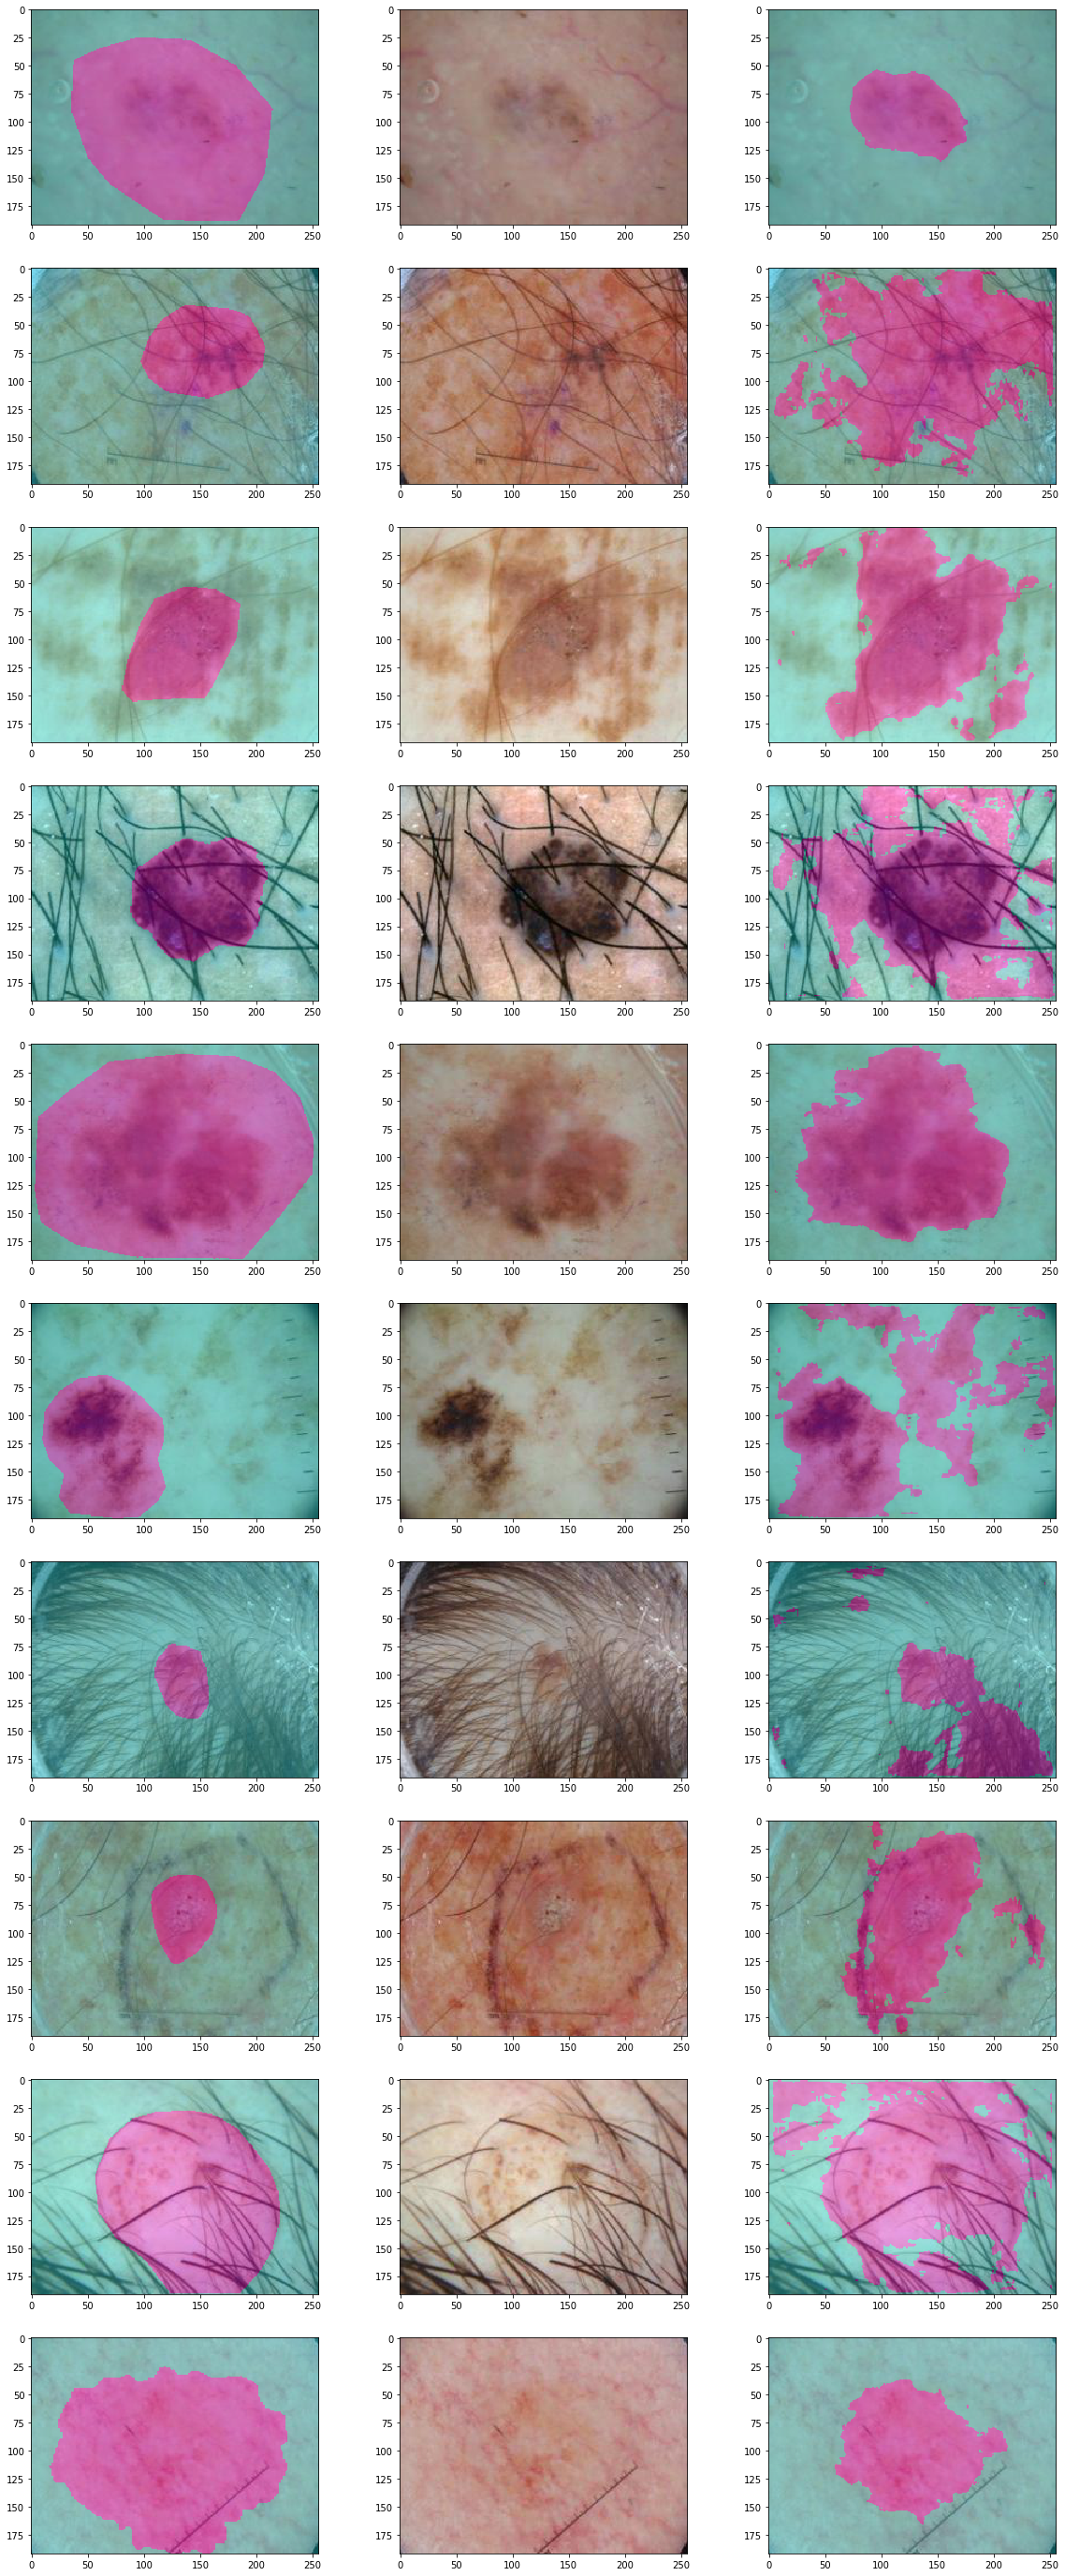

In [0]:
show_pairs_max_overlay(deeplab, idx_loss_train, train_img_x, train_img_y)

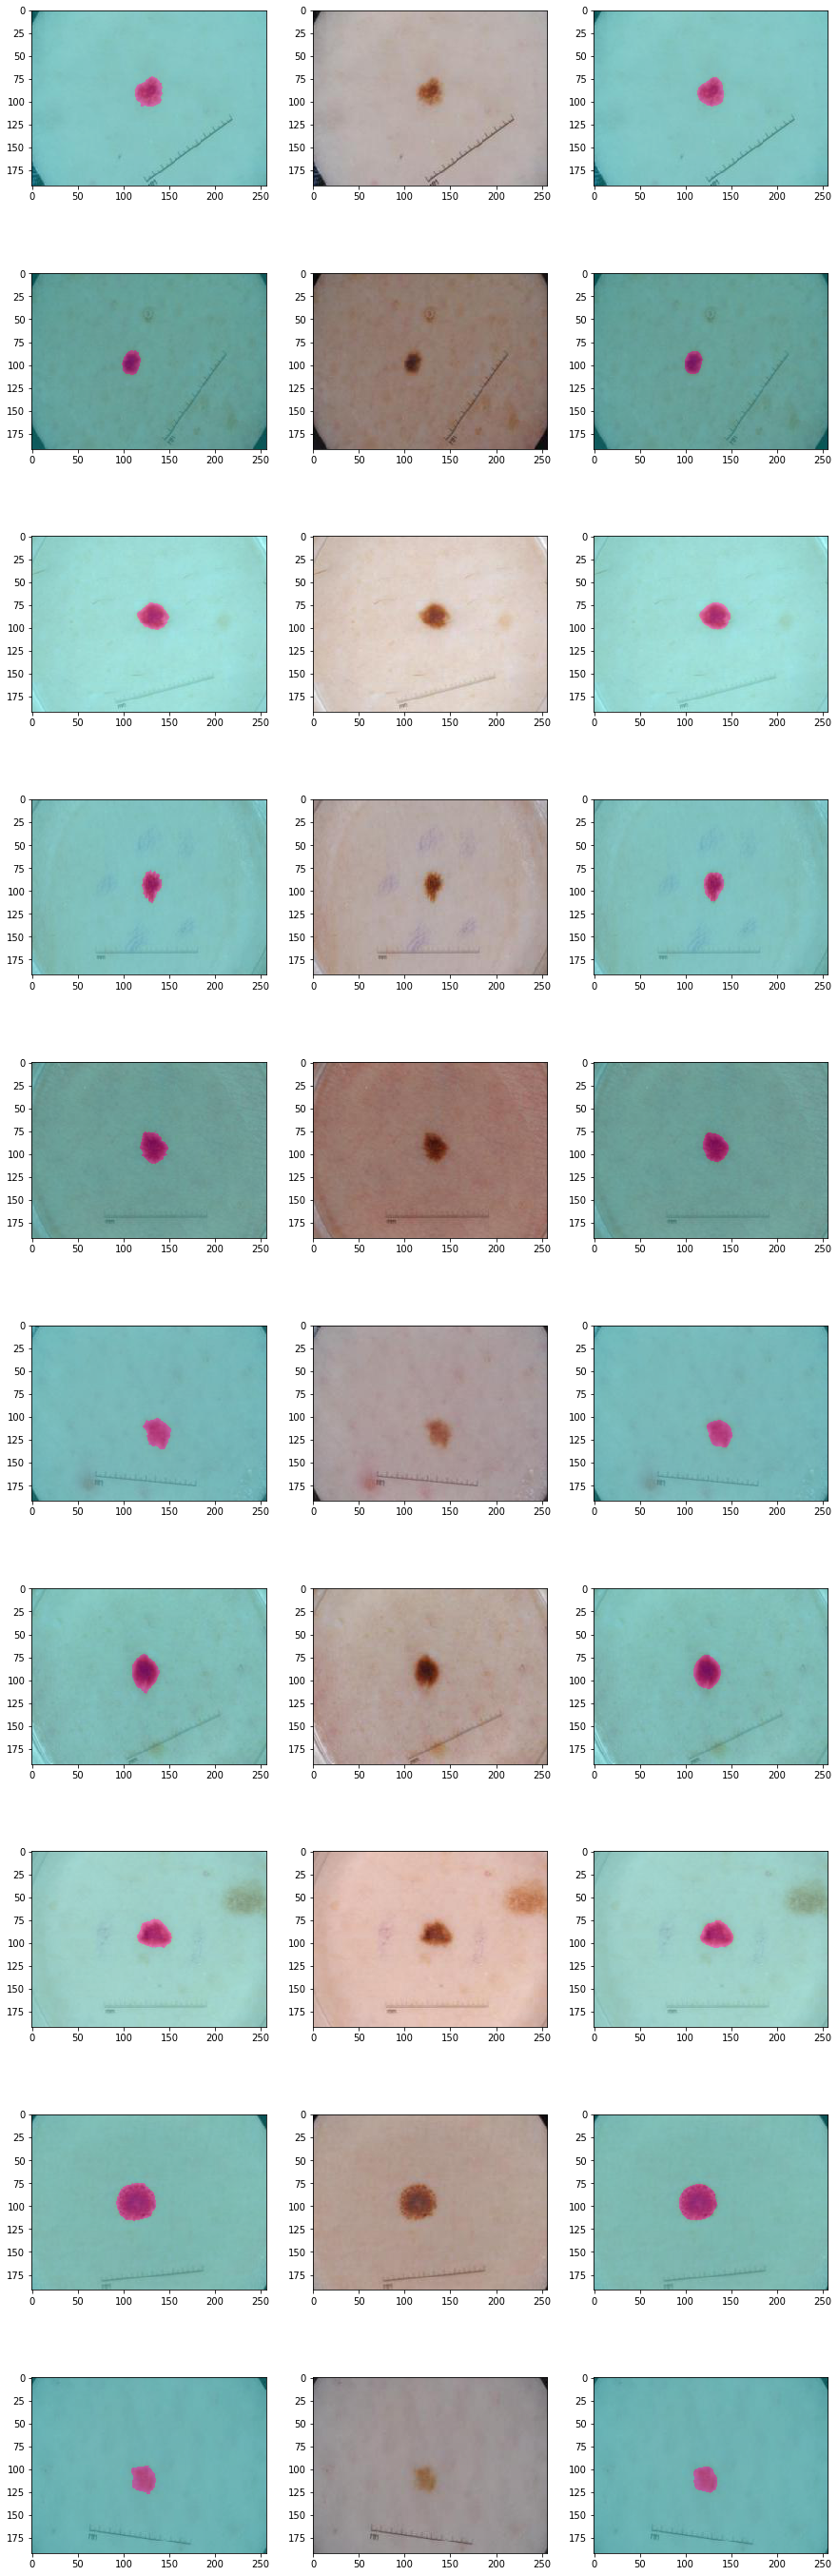

In [0]:
show_pairs_min_overlay(deeplab, idx_loss_test, test_img_x, test_img_y)

## Sort Test data by loss

In [0]:
idx_loss_test = get_sorted_loss_images(deeplab, test_img_x, test_img_y)

600it [00:22, 27.09it/s]


## Show Test samples with most and those with least accuracy

## Least Accurate predictions
###(dataset | image | model's prediction)

the model's prediction seem better than the dataset for some examples here!

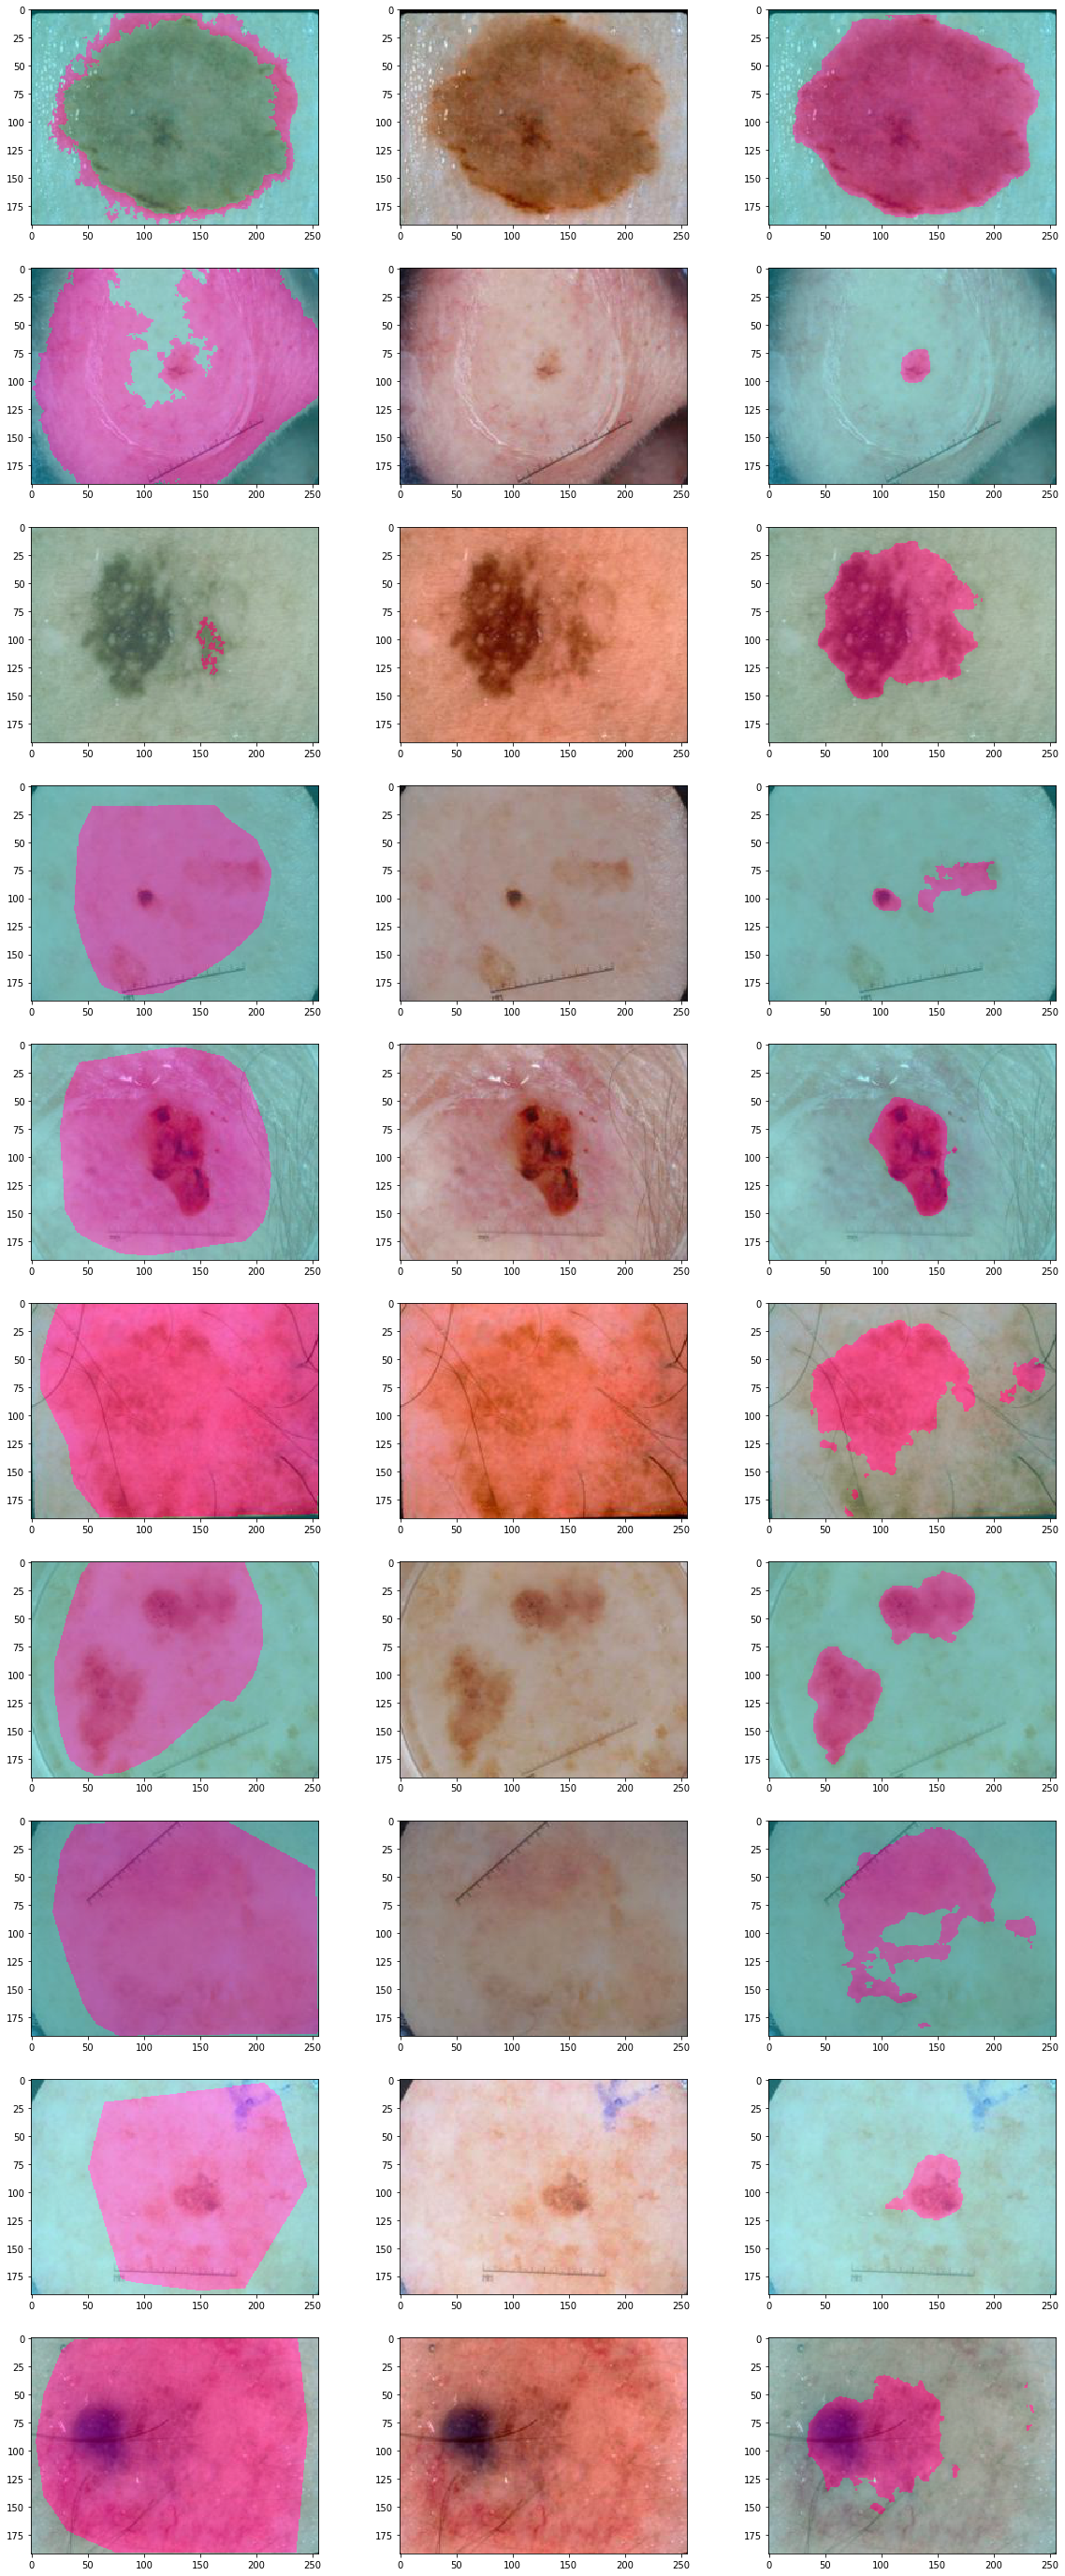

In [0]:
show_pairs_max_overlay(deeplab, idx_loss_test, test_img_x, test_img_y)

## Most Accurate Predictions

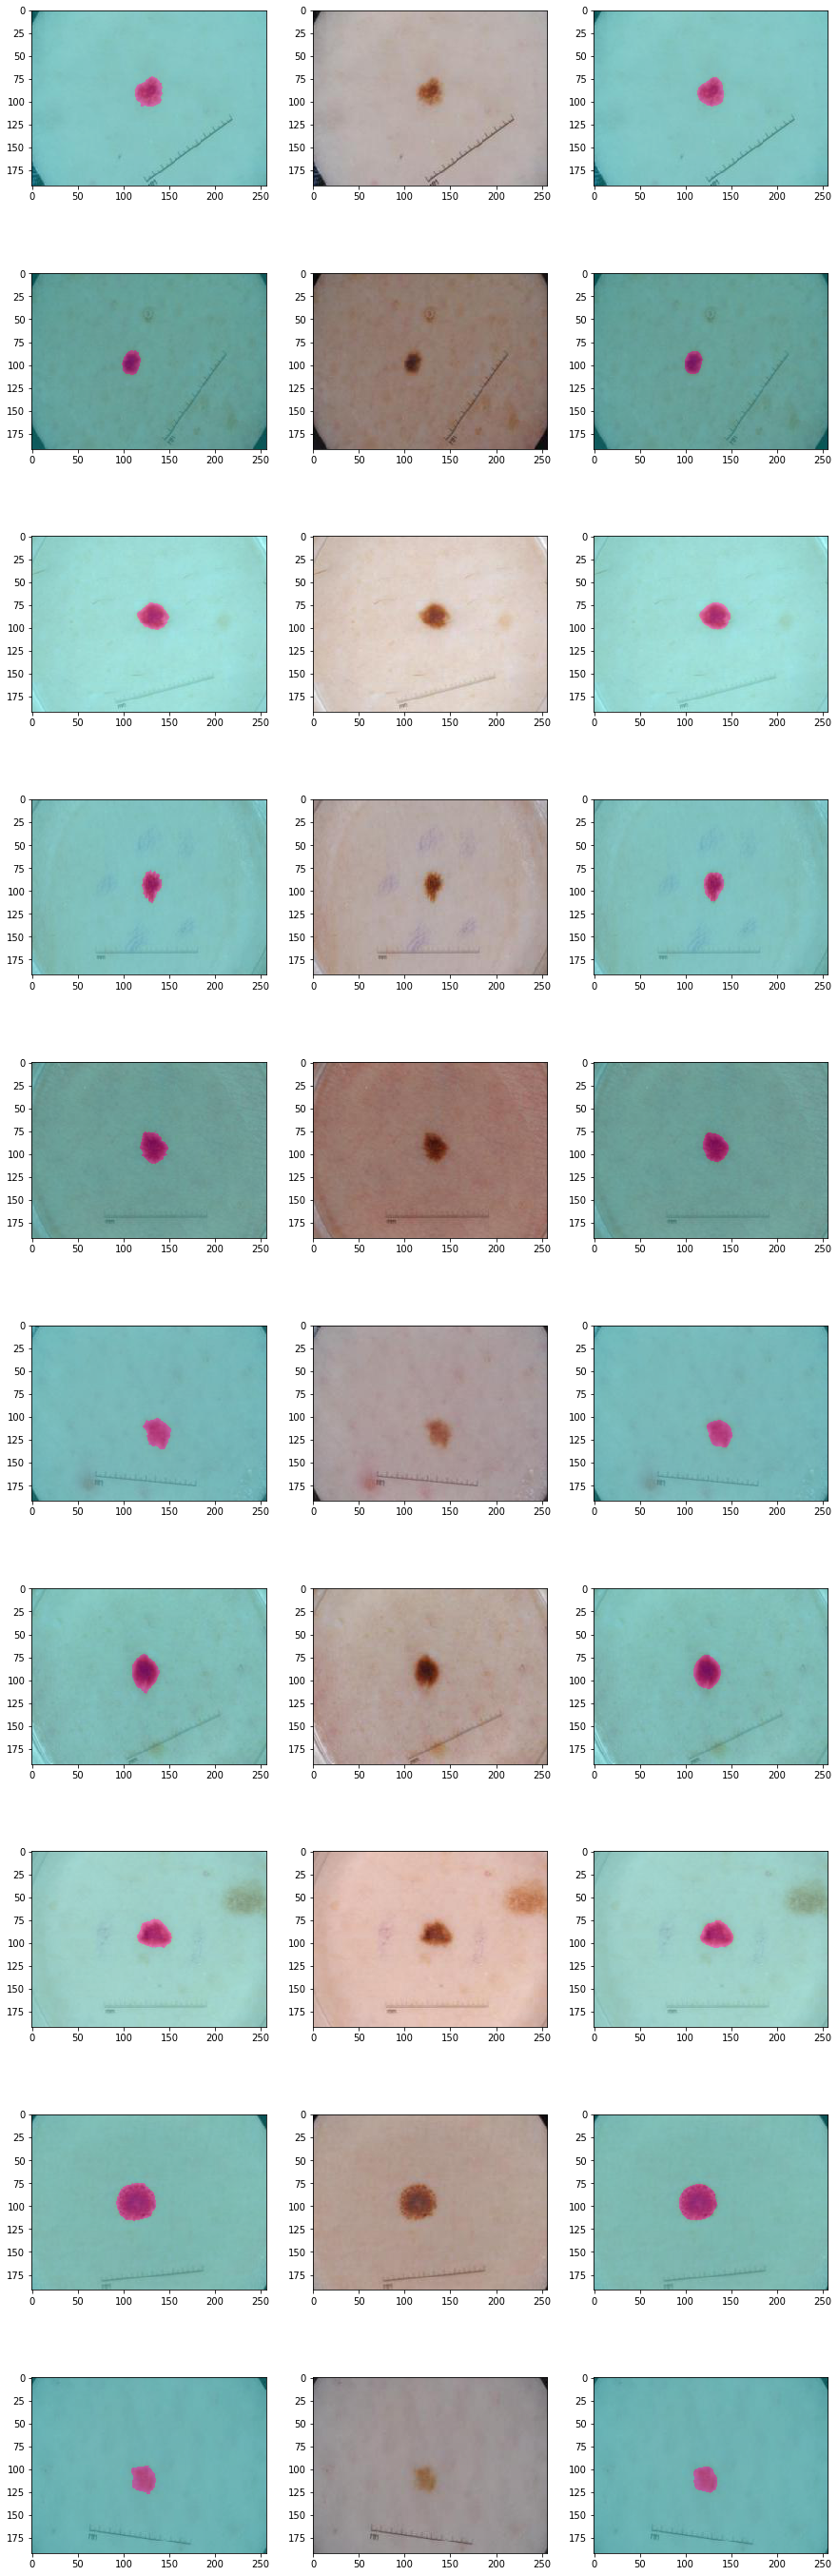

In [0]:
show_pairs_min_overlay(deeplab, idx_loss_test, test_img_x, test_img_y)

### Problems discovered in dataset
Some of the examples in the least accurate predictions seem to be really problems in the dataset. Our model's predictions seem to be actually reasonable.